# Introduction

## Objectif du Notebook
L'objectif de ce notebook est de développer et d'évaluer des modèles avancés d'analyse de sentiments en utilisant des architectures de réseaux de neurones convolutionnels (CNN) et de réseaux de neurones récurrents (LSTM). Ces modèles seront entraînés sur un jeu de données de tweets et utiliseront des embeddings textuels pré-entraînés tels que Word2Vec et FastText pour capturer les relations sémantiques entre les mots.

## Présentation des Méthodes CNN et LSTM
Le Convolutional Neural Network (CNN) et le Long Short-Term Memory (LSTM) sont deux types d'architectures de réseaux de neurones particulièrement adaptées au traitement des données séquentielles telles que le texte.

### CNN (Convolutional Neural Network)
Les CNN sont bien connus pour leur capacité à détecter des motifs locaux dans les données séquentielles, ce qui les rend efficaces pour capturer des n-grams de mots dans les textes. Dans ce notebook, nous utiliserons un CNN pour analyser les séquences de mots des tweets et en extraire des caractéristiques pertinentes pour la classification de sentiments.

### LSTM (Long Short-Term Memory)
Les LSTM sont un type de réseau de neurones récurrents (RNN) capable de capturer des dépendances à long terme dans des séquences de données. Cela les rend particulièrement efficaces pour comprendre le contexte complet d'une phrase ou d'un tweet, en tenant compte de l'ordre des mots et des relations temporelles.

## Plan du Notebook
Ce notebook est structuré de manière à suivre un pipeline complet de traitement des données, d'entraînement des modèles et d'évaluation des performances :
1. **Chargement et Préparation des Données** : Nous allons commencer par charger les données, les nettoyer, les tokeniser et les préparer pour les modèles CNN et LSTM.
2. **Préparation des Embeddings Textuels** : Nous utiliserons Word2Vec et FastText pour convertir les séquences de mots en vecteurs denses.
3. **Construction du Modèle CNN** : Nous définirons un modèle CNN pour la tâche de classification de sentiments.
4. **Construction du Modèle LSTM** : Nous définirons un modèle LSTM pour la même tâche.
5. **Entrainement des modèles** : Nous entrainerons les deux modèles.
6. **Comparaison des modèles** : Nous allons comparer les différents modèles.
7. **Export du meilleur modèle** : Nous allons exporter le modèle le plus performant pour notre analyse des sentiments.


# 1. Chargement et Préparation des Données

## 1.1 Importation des bibliothèques nécessaires


In [2]:
import numpy as np
import pandas as pd
import mlflow
import mlflow.keras
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import gensim.downloader as api
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


In [4]:
print(tf.__version__)

NameError: name 'tf' is not defined

## 1.2 Chargement des données et transformation de la cible target


In [7]:
# Charger les données
data = pd.read_csv('../data/database_p7_rework.csv')

# Transformation des labels : 0 reste 0 et 4 devient 1
data['target_binary'] = data['target'].apply(lambda x: 0 if x == 0 else 1)

# Vérification des transformations
print("Unique values in target_binary:", data['target_binary'].unique())



Unique values in target_binary: [0 1]


## 1.3 Tokenisation

In [9]:
# Fonction pour préparer les séquences
def prepare_sequences(texts, tokenizer, maxlen=25):
    sequences = tokenizer.texts_to_sequences(texts)
    return pad_sequences(sequences, maxlen=maxlen)

# Tokenization
tokenizer_lemma = Tokenizer(num_words=5000)
tokenizer_lemma.fit_on_texts(data['text_lemmatized'])

tokenizer_stem = Tokenizer(num_words=5000)
tokenizer_stem.fit_on_texts(data['text_stemmed'])

# Préparation des séquences
X_lemma = prepare_sequences(data['text_lemmatized'], tokenizer_lemma)
X_stem = prepare_sequences(data['text_stemmed'], tokenizer_stem)

# Séparation des données
y = data['target_binary']

X_train_lemma, X_test_lemma, y_train_lemma, y_test_lemma = train_test_split(X_lemma, y, test_size=0.2, random_state=42)
X_train_stem, X_test_stem, y_train_stem, y_test_stem = train_test_split(X_stem, y, test_size=0.2, random_state=42)

# 2 Préparation des Embeddings Textuels

In [11]:
# Charger les modèles Word2Vec et FastText pré-entraînés (300 dimensions)
w2v_model = api.load('word2vec-google-news-300')
ft_model = api.load('fasttext-wiki-news-subwords-300')

# Fonction pour créer la matrice d'embeddings
def create_embedding_matrix(tokenizer, embedding_model, embedding_dim=300):
    embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, embedding_dim))
    for word, i in tokenizer.word_index.items():
        if word in embedding_model:
            embedding_matrix[i] = embedding_model[word]
    return embedding_matrix





In [12]:
# Créer les matrices d'embeddings
embedding_matrix_lemma_w2v = create_embedding_matrix(tokenizer_lemma, w2v_model)
embedding_matrix_stem_w2v = create_embedding_matrix(tokenizer_stem, w2v_model)

embedding_matrix_lemma_ft = create_embedding_matrix(tokenizer_lemma, ft_model)
embedding_matrix_stem_ft = create_embedding_matrix(tokenizer_stem, ft_model)

# 3. Définition de l'architecture du modèle CNN

In [14]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout

# Fonction pour créer un modèle CNN
def create_cnn_model(input_dim, embedding_matrix, max_length=100):
    model = Sequential()
    model.add(Embedding(input_dim=input_dim, output_dim=embedding_matrix.shape[1], weights=[embedding_matrix], input_length=max_length, trainable=False))
    model.add(Conv1D(128, kernel_size=5, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model




# 4. Définition de l'architecture du modèle LSTM

In [16]:
from keras.layers import LSTM, Bidirectional

# Fonction pour créer un modèle LSTM
def create_lstm_model(input_dim, embedding_matrix, max_length=100):
    model = Sequential()
    model.add(Embedding(input_dim=input_dim, output_dim=embedding_matrix.shape[1], weights=[embedding_matrix], input_length=max_length, trainable=False))
    model.add(Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2)))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model



# 5. Entraînement et Évaluation des Modèles

## 5.1 Entraînement des Modèles CNN et LSTM avec les Embeddings Word2Vec + lemmatisation

2024/09/25 12:31:53 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh()

All git commands will error until this is rectified.

This initial warning can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|none|n|0: for no warning or exception
    - warn|w|warning|1: for a printed warning
    - error|e|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet

D:\Master_Openclassroom\python\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 52s 3ms/step - accuracy: 0.7750 - loss: 0.4694 - val_accuracy: 0.8021 - val_loss: 0.4270
Epoch 2/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 51s 3ms/step - accuracy: 0.8094 - loss: 0.4138 - val_accuracy: 0.8073 - val_loss: 0.4192
Epoch 3/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 52s 3ms/step - accuracy: 0.8194 - loss: 0.3959 - val_accuracy: 0.8068 - val_loss: 0.4197
Epoch 4/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 52s 3ms/step - accuracy: 0.8269 - loss: 0.3815 - val_accuracy: 0.8088 - val_loss: 0.4156
Epoch 5/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 51s 3ms/step - accuracy: 0.8327 - loss: 0.3707 - val_accuracy: 0.8064 - val_loss: 0.4256
Epoch 6/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 51s 3ms/step - accuracy: 0.8381 - loss: 0.3603 - val_accuracy: 0.8091 - val_loss: 0.4215
Epoch 7/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 52s 3ms/step - accuracy: 0.8420 - loss: 0.3515 - val_accuracy: 0.8058 - val_loss: 0.4336
Epoch 8/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 53s 3ms/step - accuracy: 

2024/09/25 12:40:27 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/09/25 12:40:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


9990/9990 ━━━━━━━━━━━━━━━━━━━━ 10s 967us/step


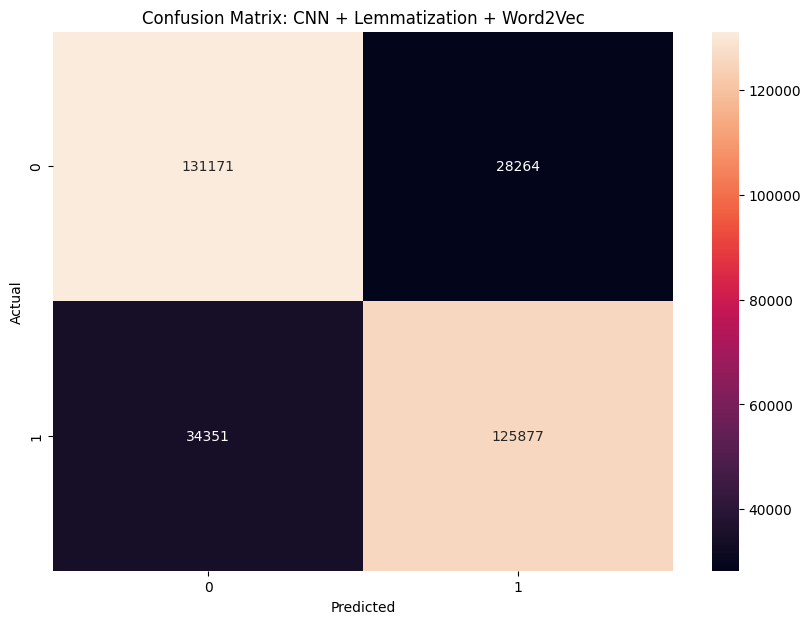

In [19]:
import mlflow
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Définir le dossier racine où vous voulez enregistrer les artefacts MLflow
base_dir = os.path.abspath(os.path.join("..", "mlruns"))

# Exemple pour CNN avec lemmatisation + Word2Vec
model_name = "cnn_model_lemma_w2v"
mlflow_base_dir = os.path.join(base_dir, model_name)

# Assurez-vous que le dossier existe
if not os.path.exists(mlflow_base_dir):
    os.makedirs(mlflow_base_dir)

# Configurer MLflow pour utiliser ce dossier comme URI de suivi
mlflow.set_tracking_uri(f"file:///{mlflow_base_dir.replace(os.sep, '/')}")

# Créer une nouvelle expérience MLflow ou utiliser une expérience existante
mlflow.set_experiment(model_name)

with mlflow.start_run():
    # Créer et entraîner le modèle
    cnn_model_lemma_w2v = create_cnn_model(len(tokenizer_lemma.word_index) + 1, embedding_matrix_lemma_w2v)
    cnn_model_lemma_w2v.fit(X_train_lemma, y_train_lemma, batch_size=64, epochs=10, validation_split=0.2, verbose=1)

    # Enregistrer le modèle dans MLflow
    mlflow.keras.log_model(cnn_model_lemma_w2v, model_name)

    # Faire des prédictions et évaluer le modèle
    y_pred_lemma_w2v = (cnn_model_lemma_w2v.predict(X_test_lemma) > 0.5).astype("int32")
    accuracy_lemma_w2v = accuracy_score(y_test_lemma, y_pred_lemma_w2v)
    precision_lemma_w2v = precision_score(y_test_lemma, y_pred_lemma_w2v)
    recall_lemma_w2v = recall_score(y_test_lemma, y_pred_lemma_w2v)
    f1_lemma_w2v = f1_score(y_test_lemma, y_pred_lemma_w2v)

    # Enregistrer les métriques dans MLflow
    mlflow.log_metric("accuracy_lemma_w2v", accuracy_lemma_w2v)
    mlflow.log_metric("precision_lemma_w2v", precision_lemma_w2v)
    mlflow.log_metric("recall_lemma_w2v", recall_lemma_w2v)
    mlflow.log_metric("f1_lemma_w2v", f1_lemma_w2v)

    # Créer et afficher la matrice de confusion
    cm_lemma_w2v = confusion_matrix(y_test_lemma, y_pred_lemma_w2v)
    plt.figure(figsize=(10,7))
    sns.heatmap(cm_lemma_w2v, annot=True, fmt='d')
    plt.title("Confusion Matrix: CNN + Lemmatization + Word2Vec")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


D:\Master_Openclassroom\python\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 235s 14ms/step - accuracy: 0.7636 - loss: 0.4863 - val_accuracy: 0.8097 - val_loss: 0.4133
Epoch 2/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 221s 14ms/step - accuracy: 0.8082 - loss: 0.4174 - val_accuracy: 0.8178 - val_loss: 0.3981
Epoch 3/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 233s 15ms/step - accuracy: 0.8186 - loss: 0.3986 - val_accuracy: 0.8227 - val_loss: 0.3933
Epoch 4/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 233s 15ms/step - accuracy: 0.8240 - loss: 0.3882 - val_accuracy: 0.8249 - val_loss: 0.3883
Epoch 5/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 234s 15ms/step - accuracy: 0.8286 - loss: 0.3805 - val_accuracy: 0.8265 - val_loss: 0.3857
Epoch 6/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 244s 15ms/step - accuracy: 0.8314 - loss: 0.3748 - val_accuracy: 0.8270 - val_loss: 0.3834
Epoch 7/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 250s 16ms/step - accuracy: 0.8343 - loss: 0.3690 - val_accuracy: 0.8278 - val_loss: 0.3847
Epoch 8/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 253s 16ms/s

2024/09/25 13:21:26 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/09/25 13:21:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


9990/9990 ━━━━━━━━━━━━━━━━━━━━ 49s 5ms/step


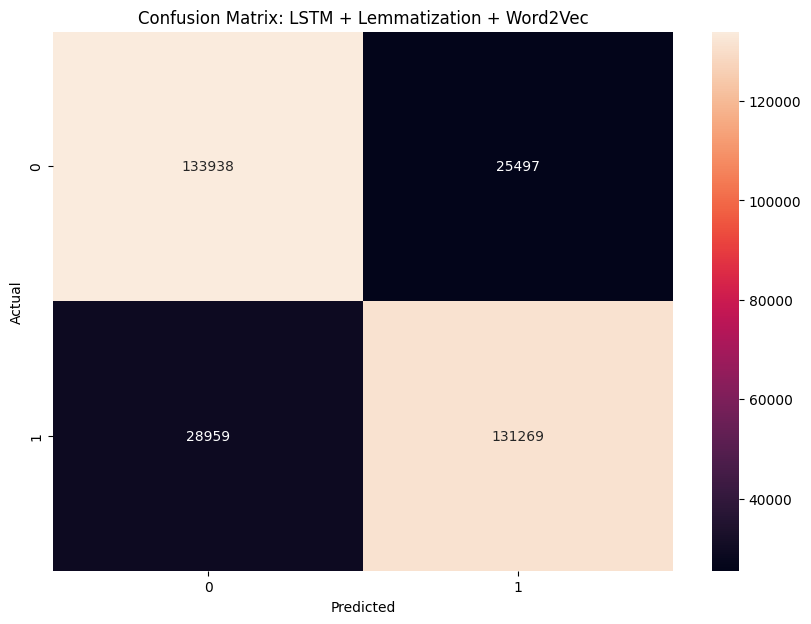

In [20]:
# Exemple pour LSTM avec lemmatisation + Word2Vec
model_name = "lstm_model_lemma_w2v"
mlflow_base_dir = os.path.join(base_dir, model_name)

if not os.path.exists(mlflow_base_dir):
    os.makedirs(mlflow_base_dir)

mlflow.set_tracking_uri(f"file:///{mlflow_base_dir.replace(os.sep, '/')}")

mlflow.set_experiment(model_name)

with mlflow.start_run():
    lstm_model_lemma_w2v = create_lstm_model(len(tokenizer_lemma.word_index) + 1, embedding_matrix_lemma_w2v)
    lstm_model_lemma_w2v.fit(X_train_lemma, y_train_lemma, batch_size=64, epochs=10, validation_split=0.2, verbose=1)

    mlflow.keras.log_model(lstm_model_lemma_w2v, model_name)

    y_pred_lemma_w2v = (lstm_model_lemma_w2v.predict(X_test_lemma) > 0.5).astype("int32")
    lstm_accuracy_lemma_w2v = accuracy_score(y_test_lemma, y_pred_lemma_w2v)
    lstm_precision_lemma_w2v = precision_score(y_test_lemma, y_pred_lemma_w2v)
    lstm_recall_lemma_w2v = recall_score(y_test_lemma, y_pred_lemma_w2v)
    lstm_f1_lemma_w2v = f1_score(y_test_lemma, y_pred_lemma_w2v)

    mlflow.log_metrics({
        "accuracy": lstm_accuracy_lemma_w2v,
        "precision": lstm_precision_lemma_w2v,
        "recall": lstm_recall_lemma_w2v,
        "f1_score": lstm_f1_lemma_w2v
    })

    cm_lemma_w2v = confusion_matrix(y_test_lemma, y_pred_lemma_w2v)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm_lemma_w2v, annot=True, fmt='d')
    plt.title("Confusion Matrix: LSTM + Lemmatization + Word2Vec")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


## 5.2 Entraînement des Modèles CNN et LSTM avec les Embeddings FastText + lemmatisation

D:\Master_Openclassroom\python\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 54s 3ms/step - accuracy: 0.7698 - loss: 0.4776 - val_accuracy: 0.7983 - val_loss: 0.4334
Epoch 2/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 52s 3ms/step - accuracy: 0.8056 - loss: 0.4210 - val_accuracy: 0.8067 - val_loss: 0.4201
Epoch 3/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 52s 3ms/step - accuracy: 0.8145 - loss: 0.4047 - val_accuracy: 0.8021 - val_loss: 0.4276
Epoch 4/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 52s 3ms/step - accuracy: 0.8203 - loss: 0.3942 - val_accuracy: 0.8095 - val_loss: 0.4166
Epoch 5/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 55s 3ms/step - accuracy: 0.8249 - loss: 0.3848 - val_accuracy: 0.8072 - val_loss: 0.4195
Epoch 6/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 52s 3ms/step - accuracy: 0.8295 - loss: 0.3769 - val_accuracy: 0.8106 - val_loss: 0.4131
Epoch 7/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 53s 3ms/step - accuracy: 0.8324 - loss: 0.3710 - val_accuracy: 0.8109 - val_loss: 0.4139
Epoch 8/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 50s 3ms/step - accuracy: 

2024/09/25 13:31:04 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/09/25 13:31:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


9990/9990 ━━━━━━━━━━━━━━━━━━━━ 9s 919us/step


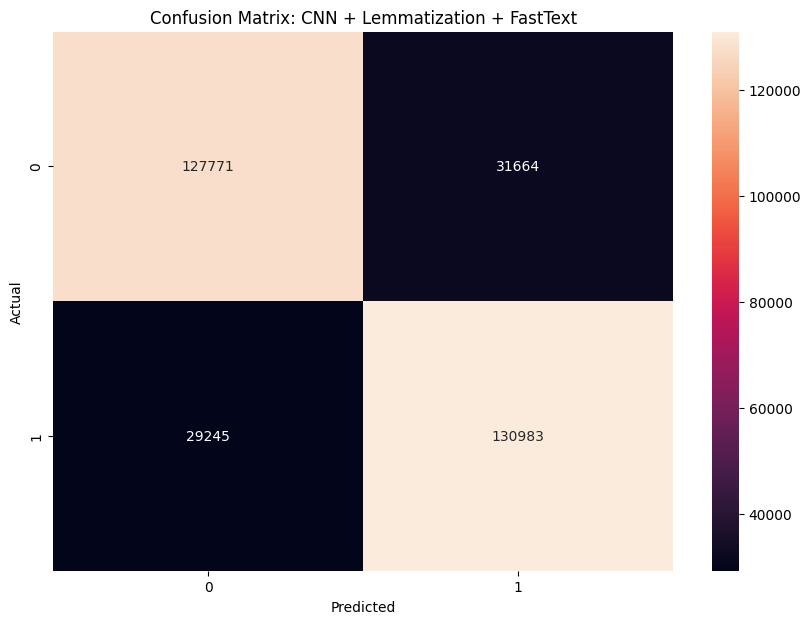

In [22]:
# Exemple pour CNN avec lemmatisation + FastText
model_name = "cnn_model_lemma_ft"
mlflow_base_dir = os.path.join(base_dir, model_name)

# Assurez-vous que le dossier existe
if not os.path.exists(mlflow_base_dir):
    os.makedirs(mlflow_base_dir)

mlflow.set_tracking_uri(f"file:///{mlflow_base_dir.replace(os.sep, '/')}")

mlflow.set_experiment(model_name)

with mlflow.start_run():
    cnn_model_lemma_ft = create_cnn_model(len(tokenizer_lemma.word_index) + 1, embedding_matrix_lemma_ft)
    cnn_model_lemma_ft.fit(X_train_lemma, y_train_lemma, batch_size=64, epochs=10, validation_split=0.2, verbose=1)

    mlflow.keras.log_model(cnn_model_lemma_ft, model_name)

    y_pred_lemma_ft = (cnn_model_lemma_ft.predict(X_test_lemma) > 0.5).astype("int32")
    cnn_accuracy_lemma_ft = accuracy_score(y_test_lemma, y_pred_lemma_ft)
    cnn_precision_lemma_ft = precision_score(y_test_lemma, y_pred_lemma_ft)
    cnn_recall_lemma_ft = recall_score(y_test_lemma, y_pred_lemma_ft)
    cnn_f1_lemma_ft = f1_score(y_test_lemma, y_pred_lemma_ft)

    mlflow.log_metrics({
        "accuracy": cnn_accuracy_lemma_ft,
        "precision": cnn_precision_lemma_ft,
        "recall": cnn_recall_lemma_ft,
        "f1_score": cnn_f1_lemma_ft
    })

    cm_lemma_ft = confusion_matrix(y_test_lemma, y_pred_lemma_ft)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm_lemma_ft, annot=True, fmt='d')
    plt.title("Confusion Matrix: CNN + Lemmatization + FastText")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


D:\Master_Openclassroom\python\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 266s 16ms/step - accuracy: 0.7540 - loss: 0.5015 - val_accuracy: 0.8027 - val_loss: 0.4285
Epoch 2/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 300s 19ms/step - accuracy: 0.8007 - loss: 0.4295 - val_accuracy: 0.8138 - val_loss: 0.4059
Epoch 3/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 304s 19ms/step - accuracy: 0.8116 - loss: 0.4116 - val_accuracy: 0.8185 - val_loss: 0.3976
Epoch 4/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 290s 18ms/step - accuracy: 0.8184 - loss: 0.3996 - val_accuracy: 0.8215 - val_loss: 0.3921
Epoch 5/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 286s 18ms/step - accuracy: 0.8221 - loss: 0.3926 - val_accuracy: 0.8229 - val_loss: 0.3911
Epoch 6/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 313s 20ms/step - accuracy: 0.8251 - loss: 0.3857 - val_accuracy: 0.8256 - val_loss: 0.3845
Epoch 7/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 331s 21ms/step - accuracy: 0.8285 - loss: 0.3797 - val_accuracy: 0.8266 - val_loss: 0.3834
Epoch 8/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 346s 22ms/s

2024/09/25 14:24:13 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/09/25 14:24:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


9990/9990 ━━━━━━━━━━━━━━━━━━━━ 56s 6ms/step


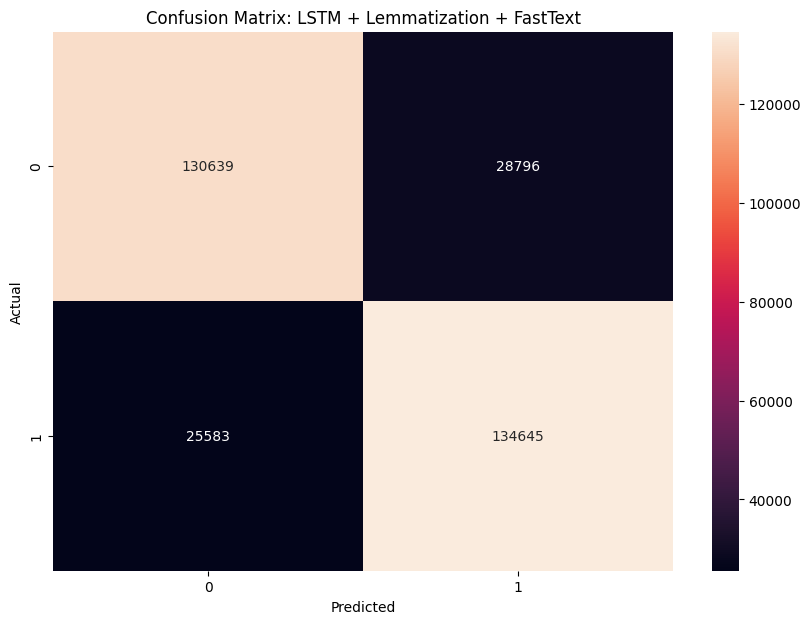

In [23]:
# Exemple pour LSTM avec lemmatisation + FastText
model_name = "lstm_model_lemma_ft"
mlflow_base_dir = os.path.join(base_dir, model_name)

if not os.path.exists(mlflow_base_dir):
    os.makedirs(mlflow_base_dir)

mlflow.set_tracking_uri(f"file:///{mlflow_base_dir.replace(os.sep, '/')}")

mlflow.set_experiment(model_name)

with mlflow.start_run():
    lstm_model_lemma_ft = create_lstm_model(len(tokenizer_lemma.word_index) + 1, embedding_matrix_lemma_ft)
    lstm_model_lemma_ft.fit(X_train_lemma, y_train_lemma, batch_size=64, epochs=10, validation_split=0.2, verbose=1)

    mlflow.keras.log_model(lstm_model_lemma_ft, model_name)

    y_pred_lemma_ft = (lstm_model_lemma_ft.predict(X_test_lemma) > 0.5).astype("int32")
    lstm_accuracy_lemma_ft = accuracy_score(y_test_lemma, y_pred_lemma_ft)
    lstm_precision_lemma_ft = precision_score(y_test_lemma, y_pred_lemma_ft)
    lstm_recall_lemma_ft = recall_score(y_test_lemma, y_pred_lemma_ft)
    lstm_f1_lemma_ft = f1_score(y_test_lemma, y_pred_lemma_ft)

    mlflow.log_metrics({
        "accuracy": lstm_accuracy_lemma_ft,
        "precision": lstm_precision_lemma_ft,
        "recall": lstm_recall_lemma_ft,
        "f1_score": lstm_f1_lemma_ft
    })

    cm_lemma_ft = confusion_matrix(y_test_lemma, y_pred_lemma_ft)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm_lemma_ft, annot=True, fmt='d')
    plt.title("Confusion Matrix: LSTM + Lemmatization + FastText")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


## 5.3 Entraînement des Modèles CNN et LSTM avec les Embeddings Word2Vec + stemming

D:\Master_Openclassroom\python\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 58s 4ms/step - accuracy: 0.7596 - loss: 0.4924 - val_accuracy: 0.7873 - val_loss: 0.4492
Epoch 2/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 56s 4ms/step - accuracy: 0.7960 - loss: 0.4368 - val_accuracy: 0.7950 - val_loss: 0.4383
Epoch 3/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 57s 4ms/step - accuracy: 0.8065 - loss: 0.4178 - val_accuracy: 0.7959 - val_loss: 0.4358
Epoch 4/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 58s 4ms/step - accuracy: 0.8146 - loss: 0.4035 - val_accuracy: 0.7948 - val_loss: 0.4392
Epoch 5/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 58s 4ms/step - accuracy: 0.8205 - loss: 0.3926 - val_accuracy: 0.7976 - val_loss: 0.4398
Epoch 6/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 57s 4ms/step - accuracy: 0.8253 - loss: 0.3831 - val_accuracy: 0.7975 - val_loss: 0.4471
Epoch 7/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 57s 4ms/step - accuracy: 0.8300 - loss: 0.3744 - val_accuracy: 0.7964 - val_loss: 0.4442
Epoch 8/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 57s 4ms/step - accuracy: 

2024/09/25 14:34:58 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/09/25 14:35:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


9990/9990 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step


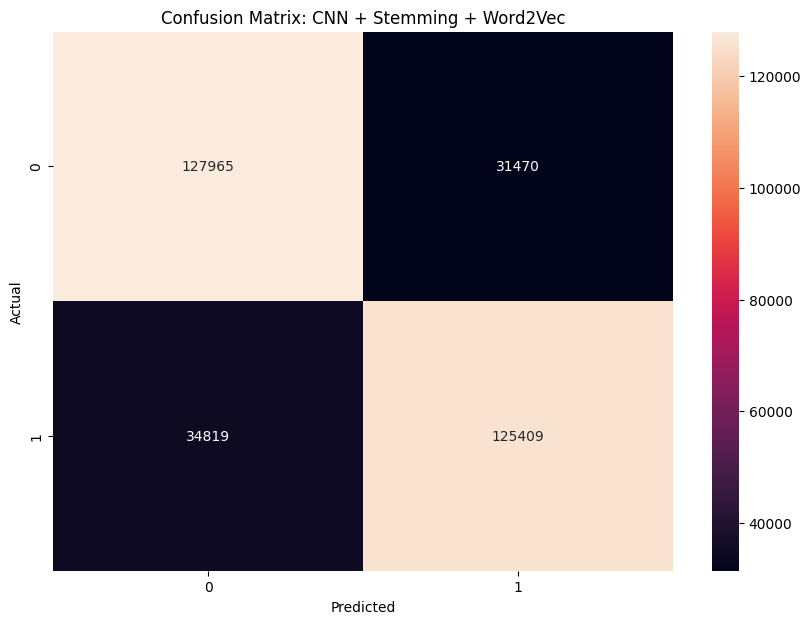

In [25]:
# Exemple pour CNN avec stemming + Word2Vec
model_name = "cnn_model_stem_w2v"
mlflow_base_dir = os.path.join(base_dir, model_name)

if not os.path.exists(mlflow_base_dir):
    os.makedirs(mlflow_base_dir)

mlflow.set_tracking_uri(f"file:///{mlflow_base_dir.replace(os.sep, '/')}")

mlflow.set_experiment(model_name)

with mlflow.start_run():
    cnn_model_stem_w2v = create_cnn_model(len(tokenizer_stem.word_index) + 1, embedding_matrix_stem_w2v)
    cnn_model_stem_w2v.fit(X_train_stem, y_train_stem, batch_size=64, epochs=10, validation_split=0.2, verbose=1)

    mlflow.keras.log_model(cnn_model_stem_w2v, model_name)

    y_pred_stem_w2v = (cnn_model_stem_w2v.predict(X_test_stem) > 0.5).astype("int32")
    cnn_accuracy_stem_w2v = accuracy_score(y_test_stem, y_pred_stem_w2v)
    cnn_precision_stem_w2v = precision_score(y_test_stem, y_pred_stem_w2v)
    cnn_recall_stem_w2v = recall_score(y_test_stem, y_pred_stem_w2v)
    cnn_f1_stem_w2v = f1_score(y_test_stem, y_pred_stem_w2v)

    mlflow.log_metrics({
        "accuracy": cnn_accuracy_stem_w2v,
        "precision": cnn_precision_stem_w2v,
        "recall": cnn_recall_stem_w2v,
        "f1_score": cnn_f1_stem_w2v
    })

    cm_stem_w2v = confusion_matrix(y_test_stem, y_pred_stem_w2v)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm_stem_w2v, annot=True, fmt='d')
    plt.title("Confusion Matrix: CNN + Stemming + Word2Vec")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


D:\Master_Openclassroom\python\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 492s 31ms/step - accuracy: 0.7502 - loss: 0.5058 - val_accuracy: 0.7957 - val_loss: 0.4355
Epoch 2/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 479s 30ms/step - accuracy: 0.7946 - loss: 0.4387 - val_accuracy: 0.8053 - val_loss: 0.4230
Epoch 3/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 513s 32ms/step - accuracy: 0.8049 - loss: 0.4212 - val_accuracy: 0.8107 - val_loss: 0.4116
Epoch 4/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 543s 34ms/step - accuracy: 0.8122 - loss: 0.4093 - val_accuracy: 0.8137 - val_loss: 0.4078
Epoch 5/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 556s 35ms/step - accuracy: 0.8170 - loss: 0.4010 - val_accuracy: 0.8145 - val_loss: 0.4061
Epoch 6/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 593s 37ms/step - accuracy: 0.8201 - loss: 0.3943 - val_accuracy: 0.8163 - val_loss: 0.4026
Epoch 7/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 595s 37ms/step - accuracy: 0.8228 - loss: 0.3896 - val_accuracy: 0.8166 - val_loss: 0.4031
Epoch 8/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 614s 38ms/s

2024/09/25 16:10:37 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/09/25 16:10:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


9990/9990 ━━━━━━━━━━━━━━━━━━━━ 101s 10ms/step


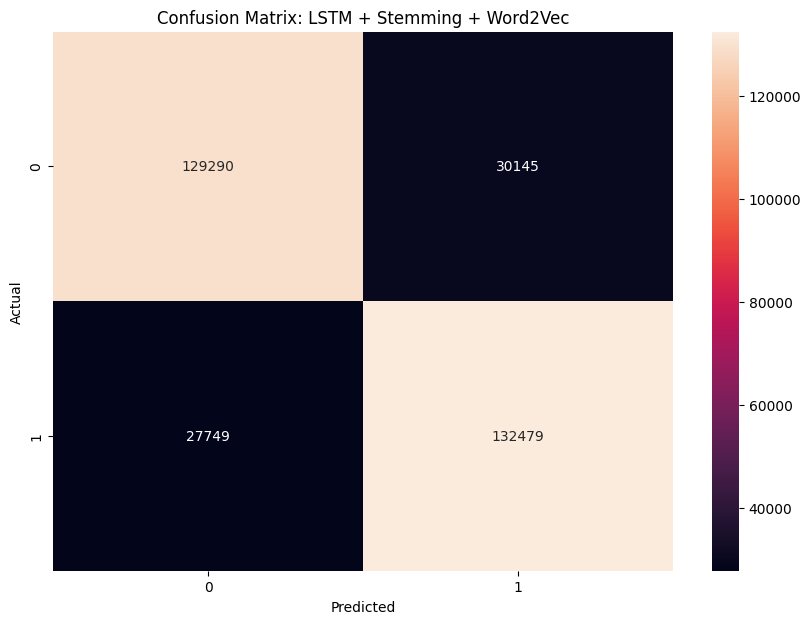

In [26]:
# Exemple pour LSTM avec stemming + Word2Vec
model_name = "lstm_model_stem_w2v"
mlflow_base_dir = os.path.join(base_dir, model_name)

if not os.path.exists(mlflow_base_dir):
    os.makedirs(mlflow_base_dir)

mlflow.set_tracking_uri(f"file:///{mlflow_base_dir.replace(os.sep, '/')}")

mlflow.set_experiment(model_name)

with mlflow.start_run():
    lstm_model_stem_w2v = create_lstm_model(len(tokenizer_stem.word_index) + 1, embedding_matrix_stem_w2v)
    lstm_model_stem_w2v.fit(X_train_stem, y_train_stem, batch_size=64, epochs=10, validation_split=0.2, verbose=1)

    mlflow.keras.log_model(lstm_model_stem_w2v, model_name)

    y_pred_stem_w2v = (lstm_model_stem_w2v.predict(X_test_stem) > 0.5).astype("int32")
    lstm_accuracy_stem_w2v = accuracy_score(y_test_stem, y_pred_stem_w2v)
    lstm_precision_stem_w2v = precision_score(y_test_stem, y_pred_stem_w2v)
    lstm_recall_stem_w2v = recall_score(y_test_stem, y_pred_stem_w2v)
    lstm_f1_stem_w2v = f1_score(y_test_stem, y_pred_stem_w2v)

    mlflow.log_metrics({
        "accuracy": lstm_accuracy_stem_w2v,
        "precision": lstm_precision_stem_w2v,
        "recall": lstm_recall_stem_w2v,
        "f1_score": lstm_f1_stem_w2v
    })

    cm_stem_w2v = confusion_matrix(y_test_stem, y_pred_stem_w2v)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm_stem_w2v, annot=True, fmt='d')
    plt.title("Confusion Matrix: LSTM + Stemming + Word2Vec")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


## 5.4 Entraînement des Modèles CNN et LSTM avec les Embeddings FastText + stemming

D:\Master_Openclassroom\python\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 65s 4ms/step - accuracy: 0.7567 - loss: 0.4949 - val_accuracy: 0.7840 - val_loss: 0.4574
Epoch 2/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 62s 4ms/step - accuracy: 0.7948 - loss: 0.4385 - val_accuracy: 0.7964 - val_loss: 0.4363
Epoch 3/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 62s 4ms/step - accuracy: 0.8047 - loss: 0.4220 - val_accuracy: 0.7988 - val_loss: 0.4323
Epoch 4/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 62s 4ms/step - accuracy: 0.8111 - loss: 0.4115 - val_accuracy: 0.7971 - val_loss: 0.4356
Epoch 5/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 61s 4ms/step - accuracy: 0.8153 - loss: 0.4031 - val_accuracy: 0.7992 - val_loss: 0.4321
Epoch 6/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 62s 4ms/step - accuracy: 0.8195 - loss: 0.3955 - val_accuracy: 0.8018 - val_loss: 0.4297
Epoch 7/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 63s 4ms/step - accuracy: 0.8228 - loss: 0.3886 - val_accuracy: 0.8000 - val_loss: 0.4311
Epoch 8/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 63s 4ms/step - accuracy: 

2024/09/25 16:23:03 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/09/25 16:23:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


9990/9990 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step


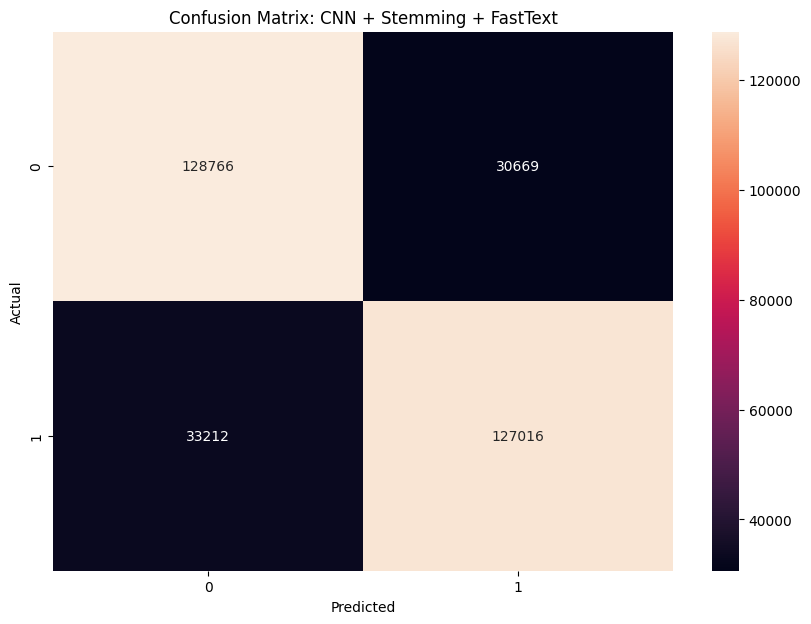

In [28]:
# Exemple pour CNN avec stemming + FastText
model_name = "cnn_model_stem_ft"
mlflow_base_dir = os.path.join(base_dir, model_name)

if not os.path.exists(mlflow_base_dir):
    os.makedirs(mlflow_base_dir)

mlflow.set_tracking_uri(f"file:///{mlflow_base_dir.replace(os.sep, '/')}")

mlflow.set_experiment(model_name)

with mlflow.start_run():
    cnn_model_stem_ft = create_cnn_model(len(tokenizer_stem.word_index) + 1, embedding_matrix_stem_ft)
    cnn_model_stem_ft.fit(X_train_stem, y_train_stem, batch_size=64, epochs=10, validation_split=0.2, verbose=1)

    mlflow.keras.log_model(cnn_model_stem_ft, model_name)

    y_pred_stem_ft = (cnn_model_stem_ft.predict(X_test_stem) > 0.5).astype("int32")
    cnn_accuracy_stem_ft = accuracy_score(y_test_stem, y_pred_stem_ft)
    cnn_precision_stem_ft = precision_score(y_test_stem, y_pred_stem_ft)
    cnn_recall_stem_ft = recall_score(y_test_stem, y_pred_stem_ft)
    cnn_f1_stem_ft = f1_score(y_test_stem, y_pred_stem_ft)

    mlflow.log_metrics({
        "accuracy": cnn_accuracy_stem_ft,
        "precision": cnn_precision_stem_ft,
        "recall": cnn_recall_stem_ft,
        "f1_score": cnn_f1_stem_ft
    })

    cm_stem_ft = confusion_matrix(y_test_stem, y_pred_stem_ft)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm_stem_ft, annot=True, fmt='d')
    plt.title("Confusion Matrix: CNN + Stemming + FastText")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


D:\Master_Openclassroom\python\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 470s 29ms/step - accuracy: 0.7393 - loss: 0.5199 - val_accuracy: 0.7924 - val_loss: 0.4438
Epoch 2/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 399s 25ms/step - accuracy: 0.7881 - loss: 0.4491 - val_accuracy: 0.8033 - val_loss: 0.4252
Epoch 3/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 430s 27ms/step - accuracy: 0.8006 - loss: 0.4302 - val_accuracy: 0.8072 - val_loss: 0.4187
Epoch 4/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 459s 29ms/step - accuracy: 0.8061 - loss: 0.4189 - val_accuracy: 0.8123 - val_loss: 0.4096
Epoch 5/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 487s 30ms/step - accuracy: 0.8110 - loss: 0.4113 - val_accuracy: 0.8131 - val_loss: 0.4068
Epoch 6/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 491s 31ms/step - accuracy: 0.8151 - loss: 0.4043 - val_accuracy: 0.8148 - val_loss: 0.4069
Epoch 7/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 512s 32ms/step - accuracy: 0.8175 - loss: 0.3991 - val_accuracy: 0.8175 - val_loss: 0.3999
Epoch 8/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 527s 33ms/s

2024/09/25 17:44:20 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/09/25 17:44:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


9990/9990 ━━━━━━━━━━━━━━━━━━━━ 95s 10ms/step


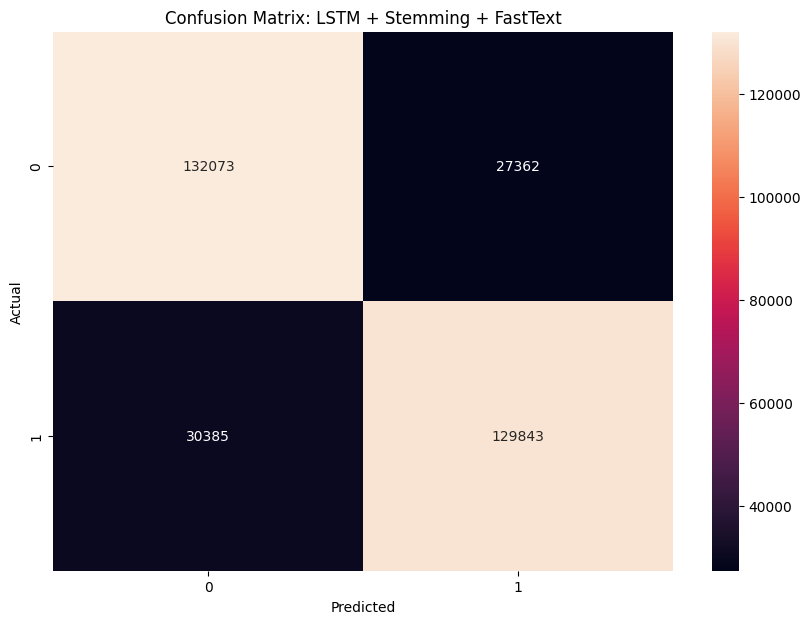

In [29]:
# Exemple pour LSTM avec stemming + FastText
model_name = "lstm_model_stem_ft"
mlflow_base_dir = os.path.join(base_dir, model_name)

if not os.path.exists(mlflow_base_dir):
    os.makedirs(mlflow_base_dir)

mlflow.set_tracking_uri(f"file:///{mlflow_base_dir.replace(os.sep, '/')}")

mlflow.set_experiment(model_name)

with mlflow.start_run():
    lstm_model_stem_ft = create_lstm_model(len(tokenizer_stem.word_index) + 1, embedding_matrix_stem_ft)
    lstm_model_stem_ft.fit(X_train_stem, y_train_stem, batch_size=64, epochs=10, validation_split=0.2, verbose=1)

    mlflow.keras.log_model(lstm_model_stem_ft, model_name)

    y_pred_stem_ft = (lstm_model_stem_ft.predict(X_test_stem) > 0.5).astype("int32")
    lstm_accuracy_stem_ft = accuracy_score(y_test_stem, y_pred_stem_ft)
    lstm_precision_stem_ft = precision_score(y_test_stem, y_pred_stem_ft)
    lstm_recall_stem_ft = recall_score(y_test_stem, y_pred_stem_ft)
    lstm_f1_stem_ft = f1_score(y_test_stem, y_pred_stem_ft)

    mlflow.log_metrics({
        "accuracy": lstm_accuracy_stem_ft,
        "precision": lstm_precision_stem_ft,
        "recall": lstm_recall_stem_ft,
        "f1_score": lstm_f1_stem_ft
    })

    cm_stem_ft = confusion_matrix(y_test_stem, y_pred_stem_ft)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm_stem_ft, annot=True, fmt='d')
    plt.title("Confusion Matrix: LSTM + Stemming + FastText")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


# 6. Comparaison des modèles

In [31]:
import pandas as pd

# Initialiser une liste pour stocker les résultats
results = []

# Fonction pour ajouter les résultats d'un modèle à la liste
def log_results(model_name, accuracy, precision, recall, f1):
    results.append({
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    })

# Log des résultats pour les modèles avancés (Word2Vec + FastText)

# CNN + Lemmatization + Word2Vec
log_results(
    'CNN + Lemmatization + Word2Vec',
    accuracy_lemma_w2v,
    precision_lemma_w2v,
    recall_lemma_w2v,
    f1_lemma_w2v
)

# LSTM + Lemmatization + Word2Vec
log_results(
    'LSTM + Lemmatization + Word2Vec',
    lstm_accuracy_lemma_w2v,
    lstm_precision_lemma_w2v,
    lstm_recall_lemma_w2v,
    lstm_f1_lemma_w2v
)

# CNN + Stemming + Word2Vec
log_results(
    'CNN + Stemming + Word2Vec',
    cnn_accuracy_stem_w2v,
    cnn_precision_stem_w2v,
    cnn_recall_stem_w2v,
    cnn_f1_stem_w2v
)

# LSTM + Stemming + Word2Vec
log_results(
    'LSTM + Stemming + Word2Vec',
    lstm_accuracy_stem_w2v,
    lstm_precision_stem_w2v,
    lstm_recall_stem_w2v,
    lstm_f1_stem_w2v
)

# CNN + Lemmatization + FastText
log_results(
    'CNN + Lemmatization + FastText',
    cnn_accuracy_lemma_ft,
    cnn_precision_lemma_ft,
    cnn_recall_lemma_ft,
    cnn_f1_lemma_ft
)

# LSTM + Lemmatization + FastText
log_results(
    'LSTM + Lemmatization + FastText',
    lstm_accuracy_lemma_ft,
    lstm_precision_lemma_ft,
    lstm_recall_lemma_ft,
    lstm_f1_lemma_ft
)

# CNN + Stemming + FastText
log_results(
    'CNN + Stemming + FastText',
    cnn_accuracy_stem_ft,
    cnn_precision_stem_ft,
    cnn_recall_stem_ft,
    cnn_f1_stem_ft
)

# LSTM + Stemming + FastText
log_results(
    'LSTM + Stemming + FastText',
    lstm_accuracy_stem_ft,
    lstm_precision_stem_ft,
    lstm_recall_stem_ft,
    lstm_f1_stem_ft
)

# Convertir les résultats en DataFrame
results_df = pd.DataFrame(results)

# Afficher le tableau récapitulatif
print(results_df)



                             Model  Accuracy  Precision    Recall  F1 Score
0   CNN + Lemmatization + Word2Vec  0.804122   0.816635  0.785612  0.800823
1  LSTM + Lemmatization + Word2Vec  0.829646   0.837356  0.819264  0.828211
2        CNN + Stemming + Word2Vec  0.792628   0.799400  0.782691  0.790957
3       LSTM + Stemming + Word2Vec  0.818891   0.814634  0.826816  0.820679
4   CNN + Lemmatization + FastText  0.809459   0.805321  0.817479  0.811354
5  LSTM + Lemmatization + FastText  0.829886   0.823814  0.840334  0.831992
6        CNN + Stemming + FastText  0.800161   0.805505  0.792720  0.799061
7       LSTM + Stemming + FastText  0.819350   0.825947  0.810364  0.818081


# 7. Export du Modèle

In [33]:
import os
import joblib

# Supposez que vous avez un dictionnaire avec les accuracies des modèles
accuracies = {
    'CNN + Lemmatization + Word2Vec': accuracy_lemma_w2v,
    'CNN + Lemmatization + FastText': cnn_accuracy_lemma_ft,
    'CNN + Stemming + Word2Vec': cnn_accuracy_stem_w2v,
    'CNN + Stemming + FastText': cnn_accuracy_stem_ft,
    'LSTM + Lemmatization + Word2Vec': lstm_accuracy_lemma_w2v,
    'LSTM + Lemmatization + FastText': lstm_accuracy_lemma_ft,
    'LSTM + Stemming + Word2Vec': lstm_accuracy_stem_w2v,
    'LSTM + Stemming + FastText': lstm_accuracy_stem_ft,
}

# Déterminez le meilleur modèle basé sur les accuracies
best_model_name = max(accuracies, key=accuracies.get)

# Selon le meilleur modèle, sélectionnez l'objet modèle correspondant
if best_model_name == 'CNN + Lemmatization + Word2Vec':
    best_model = cnn_model_lemma_w2v
elif best_model_name == 'CNN + Lemmatization + FastText':
    best_model = cnn_model_lemma_ft
elif best_model_name == 'CNN + Stemming + Word2Vec':
    best_model = cnn_model_stem_w2v
elif best_model_name == 'CNN + Stemming + FastText':
    best_model = cnn_model_stem_ft
elif best_model_name == 'LSTM + Lemmatization + Word2Vec':
    best_model = lstm_model_lemma_w2v
elif best_model_name == 'LSTM + Lemmatization + FastText':
    best_model = lstm_model_lemma_ft
elif best_model_name == 'LSTM + Stemming + Word2Vec':
    best_model = lstm_model_stem_w2v
elif best_model_name == 'LSTM + Stemming + FastText':
    best_model = lstm_model_stem_ft

# Créez le chemin vers le dossier 'models'
models_folder_path = os.path.join('..', 'models')

# Créez le dossier 'models' s'il n'existe pas
if not os.path.exists(models_folder_path):
    os.makedirs(models_folder_path)

# Sauvegardez le modèle dans le dossier 'models'
model_file_name = f"{best_model_name.replace(' ', '_').replace('+', 'plus')}_model.h5"
model_path = os.path.join(models_folder_path, model_file_name)
best_model.save(model_path)

print(f"Best model '{best_model_name}' saved at {model_path}")


Best model 'LSTM + Lemmatization + FastText' saved at ..\models\LSTM_plus_Lemmatization_plus_FastText_model.h5


In [34]:
import tensorflow as tf
import zipfile
import os


# Sauvegarder le modèle au format .h5
model_h5_path = '../models/LSTM_plus_Lemmatization_plus_FastText_model.h5'
lstm_model_lemma_ft.save(model_h5_path)

print(f"Le modèle Keras a été sauvegardé sous {model_h5_path}")

# Créer un fichier .zip contenant le modèle .h5
zip_file_path = '../models/LSTM_plus_Lemmatization_plus_FastText_model.zip'
with zipfile.ZipFile(zip_file_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
    zipf.write(model_h5_path, os.path.basename(model_h5_path))

print(f"Le modèle Keras compressé a été sauvegardé sous {zip_file_path}")


Le modèle Keras a été sauvegardé sous ../models/LSTM_plus_Lemmatization_plus_FastText_model.h5
Le modèle Keras compressé a été sauvegardé sous ../models/LSTM_plus_Lemmatization_plus_FastText_model.zip


In [6]:
import tensorflow as tf
import zipfile
import os

In [8]:
print(tf.__version__)

2.12.0
